See https://www.ams.org/journals/mcom/2005-74-250/S0025-5718-04-01678-3/viewer/

In [1]:
from functools import partial

import jax
import jax.numpy as jnp
import jax.scipy as jsp

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# jax.config.update("jax_debug_nans", True)

In [3]:
def make_gaussian_kernel(sigma, truncate=4.0):
    """Make a 2D Gaussian kernel array."""
    sigma = float(sigma)
    truncate = float(truncate)
    radius = int(np.ceil(truncate * sigma))
    size = 2 * radius + 1
    x = np.arange(size) - radius
    y = np.arange(size) - radius
    x, y = np.meshgrid(x, y)
    kernel = np.exp(-0.5 * (x**2 + y**2) / sigma**2)
    kernel /= np.sum(kernel)
    return kernel

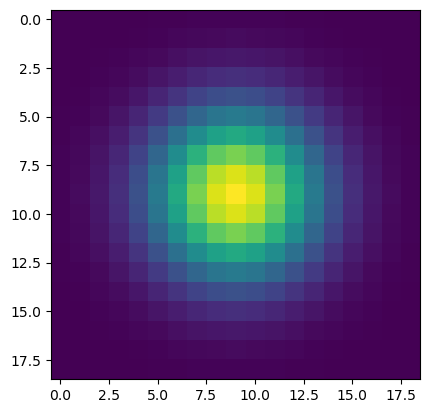

In [4]:
filt = plt.imshow(make_gaussian_kernel(3.0, truncate=3.0))

In [5]:
filt = jnp.array(make_gaussian_kernel(3.0, truncate=4.0))

key = jax.random.PRNGKey(1235235)

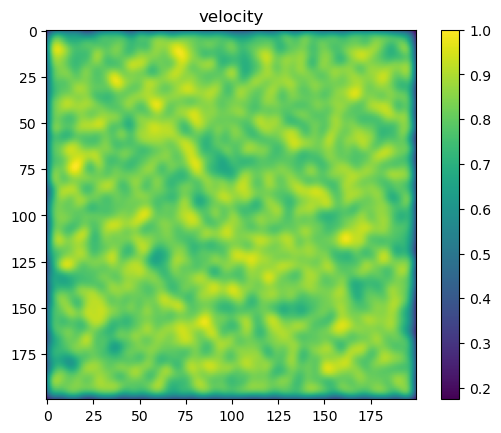

In [6]:
width = 200
image = jax.random.uniform(key, shape=(width, width))
image = jsp.signal.convolve(image, filt, mode='same', method='fft')

# Normalize to [0.1, 1]
image -= (jnp.min(image) - 0.1)
image /= jnp.max(image)

plt.title('velocity')
plt.imshow(image)
_ = plt.colorbar()

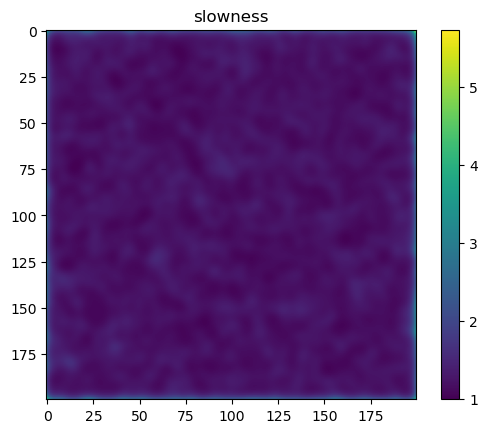

In [7]:
slowness = 1.0 / image
plt.title('slowness')
plt.imshow(slowness)
_ = plt.colorbar()

In [8]:
jnp.max(slowness)

Array(5.7329445, dtype=float32)

Array(2293.1777, dtype=float32)

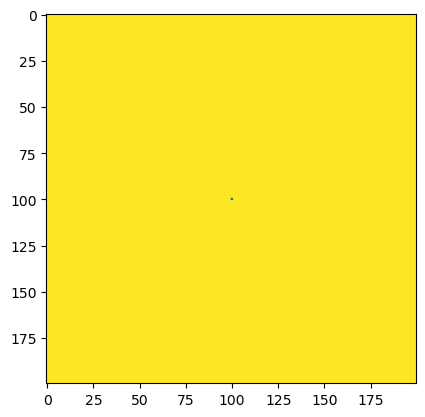

In [9]:
start_val = 2 * width * jnp.max(slowness)

start_tt = jnp.full((width, width), start_val)
start_tt = start_tt.at[width // 2, width // 2].set(0.0)

plt.imshow(jnp.minimum(start_tt, 1.0))

start_val

In [10]:
# def _lr_one(u, b, slowness):
#     """
#     Args:
#         u: the current row being processed
#         b: the minimum value of the row above or below (i.e. b in eq. 2.3)
#     """
# def _lr_one(carry, u):
#     b, slowness = carry
#     return (u, slowness), jnp.minimum(u, b)


def update_i(i, uu, slowness, bb):
    a = jnp.minimum(uu[i - 1], uu[i + 1])
    b = bb[i]
    
    w = jnp.abs(a - b) >= slowness[i]

    g = jnp.minimum(a, b) + slowness[i]
    h = (a + b + jnp.sqrt(2 * slowness[i] ** 2 - (a - b) ** 2)) / 2

    u_cand = jax.lax.select(w, g, h)
    # u = jnp.where(w, g, h)
    # u = g

    u = jnp.minimum(u_cand, uu[i])
    return uu.at[i].set(u)


def sweep_lr(uu, uu0, uu1, slowness):
    # above and below
    bb = jnp.minimum(uu0, uu1)

    return jax.lax.fori_loop(
        1, width - 1, partial(update_i, bb=bb, slowness=slowness), uu
    )


def sweep_rl(uu, uu0, uu1, slowness):
    uu = jnp.flip(uu, axis=-1)
    uu0 = jnp.flip(uu0, axis=-1)
    uu1 = jnp.flip(uu1, axis=-1)
    slowness = jnp.flip(slowness, axis=-1)

    return jnp.flip(sweep_lr(uu, uu0, uu1, slowness), axis=-1)

In [11]:
if False:
    num_iters = 1

    uu = start_tt.copy()

    for iter in range(num_iters):
        print(f"iter {iter:04d}", end="\r")

        for row_idx in range(1, width - 1):
            u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(1, width - 1):
            u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(width - 2, 0, -1):
            u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(width - 2, 0, -1):
            u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

    plt.imshow(uu[1:-1, 1:-1])            

In [12]:
if False:
    # Note that this will take FOREVER to compile the first time
    @jax.jit
    def one_iter(uu, slowness):
        width, height = uu.shape
        assert width == height

        for row_idx in range(1, width - 1):
            u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(1, width - 1):
            u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(width - 2, 0, -1):
            u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)

        for row_idx in range(width - 2, 0, -1):
            u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
            uu = uu.at[row_idx].set(u)    

        return uu


    def eikonal_solve(start_tt, num_iters):
        width, height = start_tt.shape
        assert width == height

        uu = start_tt.copy()

        for iter in range(num_iters):
            print(f"iter {iter:04d}", end="\r")

            uu = one_iter(uu, slowness)
        
        return uu

    uu = eikonal_solve(start_tt, 4)

    plt.imshow(uu[1:-1, 1:-1])

In [13]:
@jax.jit
def one_iter(uu, slowness):
    width, height = uu.shape
    assert width == height

    def sc_sweep_lr(uu, row_idx):
        u = sweep_lr(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
        return uu.at[row_idx].set(u), None
    
    def sc_sweep_rl(uu, row_idx):
        u = sweep_rl(uu[row_idx], uu[row_idx - 1], uu[row_idx + 1], slowness[row_idx])
        return uu.at[row_idx].set(u), None

    uu = jax.lax.scan(sc_sweep_lr, uu, jnp.arange(1, width - 1))[0]
    uu = jax.lax.scan(sc_sweep_rl, uu, jnp.arange(1, width - 1))[0]
    uu = jax.lax.scan(sc_sweep_lr, uu, jnp.arange(width - 2, 0, -1))[0]
    uu = jax.lax.scan(sc_sweep_rl, uu, jnp.arange(width - 2, 0, -1))[0]

    return uu


def eikonal_solve(start_tt, slowness, num_iters):
    width, height = start_tt.shape
    assert width == height

    uu = start_tt.copy()

    for iter in range(num_iters):
        print(f"iter {iter:04d}", end="\r")

        uu = one_iter(uu, slowness)
    
    return uu

In [14]:
uu = eikonal_solve(start_tt, slowness, 8)

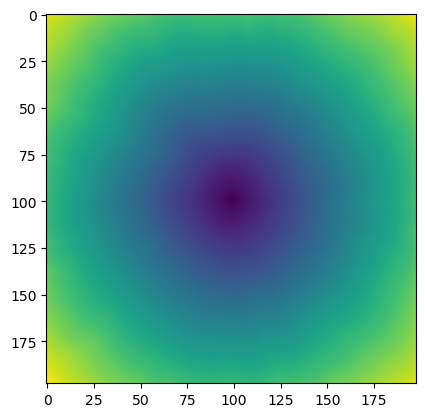

In [15]:
plt.imshow(uu[1:-1, 1:-1])

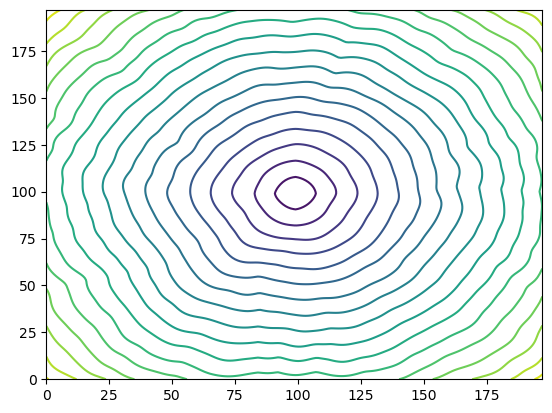

In [16]:
plt.contour(uu[1:-1, 1:-1], levels=20)

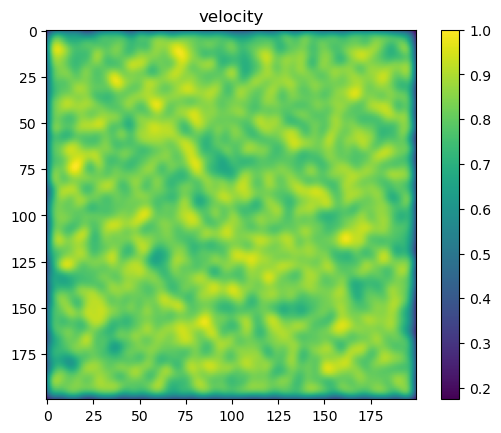

In [17]:
width = 400
# image = jax.random.uniform(key, shape=(width, width))
# image = jsp.signal.convolve(image, filt, mode='same', method='fft')

# # Normalize to [0.1, 1]
# image -= (jnp.min(image) - 0.1)
# image /= jnp.max(image)
velocity = jnp.ones((width, width))

velocity = velocity.at[150:250, 150:155].set(0.0)

plt.title('velocity')
plt.imshow(image)
_ = plt.colorbar()

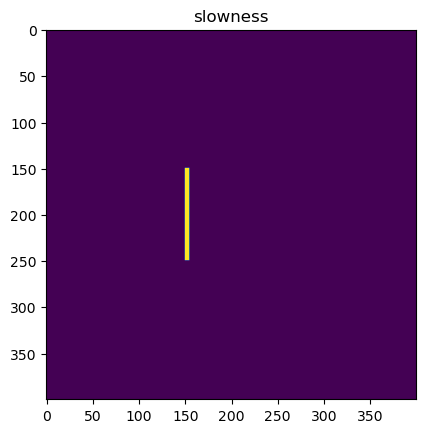

In [18]:
slowness = 1.0 / (velocity + 1e-6)
plt.title('slowness')
plt.imshow(slowness)

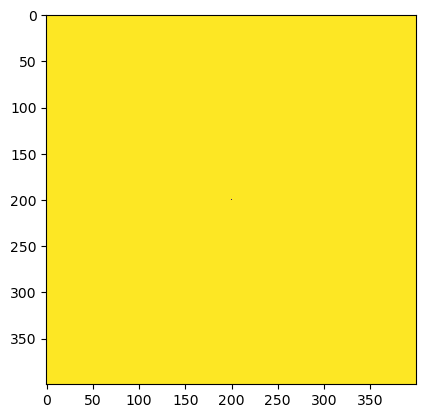

In [19]:
start_tt = jnp.full((width, width), start_val)
start_tt = start_tt.at[width // 2, width // 2].set(0.0)

plt.imshow(jnp.minimum(start_tt, 1.0))

In [20]:
uu_2 = eikonal_solve(start_tt, slowness, 2)
uu_4 = eikonal_solve(uu_2, slowness, 2)
uu_8 = eikonal_solve(uu_4, slowness, 4)
uu_16 = eikonal_solve(uu_8, slowness, 8)

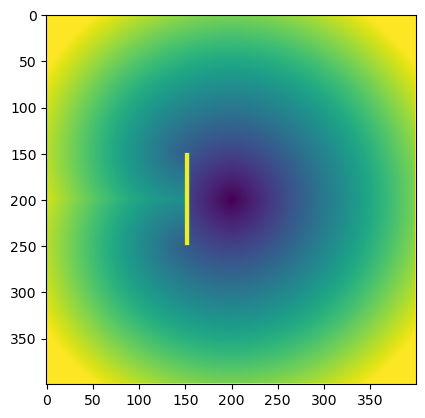

In [21]:
plt.imshow(jnp.minimum(uu_4, 250))

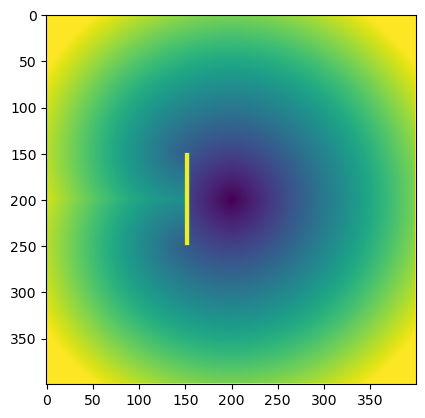

In [22]:
plt.imshow(jnp.minimum(uu_16, 250))

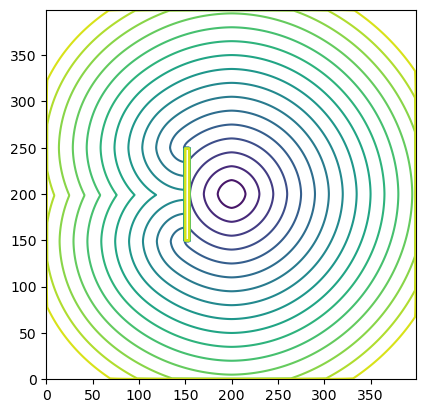

In [23]:
plt.contour(jnp.minimum(uu_4, 250), levels=20)
plt.gca().set_aspect('equal')

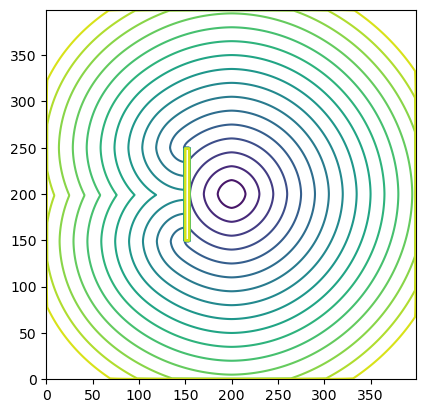

In [24]:
plt.contour(jnp.minimum(uu_16, 250), levels=20)
plt.gca().set_aspect('equal')

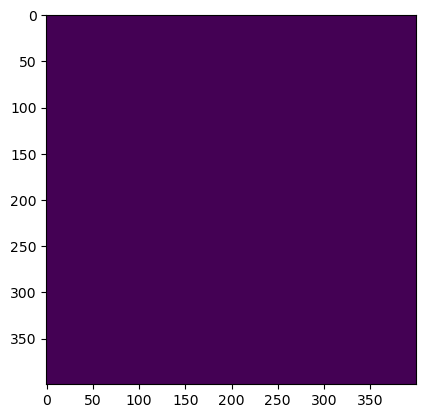

In [25]:
plt.imshow(jnp.minimum(uu_16, 250) - jnp.minimum(uu_4, 250))

In [26]:
# set aspect equal